### Importation des packages

In [27]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras import Input
from keras.layers import Dense
import seaborn as sns

import pandas as pd
import numpy as np
import os

from PIL import Image

import random

from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import matplotlib.pyplot as plt

### Exploratory Data Analysis

### Importation des données (C1)

In [8]:
# https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/data
train_dir = './datasets/plant-disease-recognition-dataset/Train/Train'
test_dir = './datasets/plant-disease-recognition-dataset/Test/Test'
val_dir = './datasets/plant-disease-recognition-dataset/Validation/Validation'

In [9]:
#check data 
directories = {
    train_dir: 'Train',
    test_dir: 'Test',
    val_dir: 'Validation'
}

subfolders = ['Healthy','Powdery','Rust']

print('\n* * * * * Number of files in each folder * * * * *\n')

for dir, name in directories.items():
    total=0
    for sub in subfolders:
        path = os.path.join(dir,sub)
        num_files = len([f for f in os.listdir(path) if os.path.join(path,f)])
        total += num_files
        print(f'\n{name}/{sub}:{num_files}')
    print(f'\n Total: {total}')
    print("-" * 80)


* * * * * Number of files in each folder * * * * *


Train/Healthy:458

Train/Powdery:430

Train/Rust:434

 Total: 1322
--------------------------------------------------------------------------------

Test/Healthy:50

Test/Powdery:50

Test/Rust:50

 Total: 150
--------------------------------------------------------------------------------

Validation/Healthy:20

Validation/Powdery:20

Validation/Rust:20

 Total: 60
--------------------------------------------------------------------------------


In [12]:
#check image dimensions
unique_dimensions = set()

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                unique_dimensions.add(img.size)

if len(unique_dimensions) == 1:
    print(f"\nAll images have the same dimensions:{unique_dimensions.pop()}")
else:
    print(f"\nFound {len(unique_dimensions)} unique image dimensions: {unique_dimensions}")


Found 8 unique image dimensions: {(4032, 3024), (4000, 2672), (4000, 3000), (5184, 3456), (2592, 1728), (3901, 2607), (4608, 3456), (2421, 2279)}


In [13]:
from collections import defaultdict

#check the distribution of these dimensions across the data
dims_counts = defaultdict(int)

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                dims_counts[img.size] += 1

for dimension, count in dims_counts.items():
    print(f"\nDimension {dimension}: {count} images")


Dimension (4000, 3000): 88 images

Dimension (4000, 2672): 1130 images

Dimension (2421, 2279): 1 images

Dimension (2592, 1728): 127 images

Dimension (5184, 3456): 97 images

Dimension (4608, 3456): 72 images

Dimension (4032, 3024): 16 images

Dimension (3901, 2607): 1 images


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Définir les générateurs pour entraîner, valider et tester les données
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalisation des images
val_datagen = ImageDataGenerator(rescale=1./255)    # Normalisation des images
test_datagen = ImageDataGenerator(rescale=1./255)   # Normalisation des images

# Charger les images d'entraînement à partir du dossier "train"
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Chemin vers le dossier d'entraînement
    target_size=(224, 224),     # Taille des images
    batch_size=32,              # Taille du lot
    class_mode='sparse'         # Utiliser 'categorical' si les étiquettes sont one-hot encodées
)

# Charger les images de validation à partir du dossier "validation"
validation_generator = val_datagen.flow_from_directory(
    val_dir,  # Chemin vers le dossier de validation
    target_size=(224, 224),           # Taille des images
    batch_size=32,                    # Taille du lot
    class_mode='sparse'               # Utiliser 'categorical' si les étiquettes sont one-hot encodées
)

# Charger les images de test à partir du dossier "test"
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Chemin vers le dossier de test
    target_size=(224, 224),    # Taille des images
    batch_size=32,             # Taille du lot
    class_mode='sparse',       # Utiliser 'categorical' si les étiquettes sont one-hot encodées
    shuffle=False              # Ne pas mélanger les images de test pour évaluer correctement le modèle
)


Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


### Train test split

In [16]:

from sklearn.model_selection import train_test_split

# Define dataset path (update the path to where your dataset is located)
dataset_dir = train_dir#'./dataset/Train/Train'

# Parameters
img_size = (224, 224)
batch_size = 32

# Load dataset from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    image_size=img_size,    # Resize all images to 224x224
    batch_size=batch_size,  # Batch size
    label_mode="int",       # Labels as integers
    shuffle=True            # Shuffle dataset
)

# Extract images (X) and labels (y) from the dataset
X, y = zip(*[(images.numpy(), labels.numpy()) for images, labels in dataset])
X = tf.concat(X, axis=0)  # Combine batches
y = tf.concat(y, axis=0)  # Combine labels

# Convert TensorFlow tensors to NumPy arrays
X = X.numpy()
y = y.numpy()

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalize pixel values (0-255 -> 0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# Output sizes of the datasets
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Found 1322 files belonging to 3 classes.
Training samples: 1057, Test samples: 265


On affiches les première images

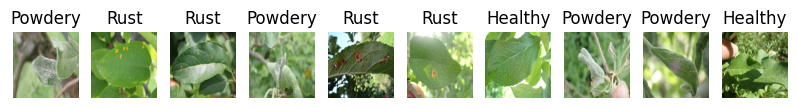

In [17]:
import matplotlib.pyplot as plt

# Function to plot the first 5 images and their labels
def plot_images(X, y, class_names, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(X[i])               # Show image
        plt.title(class_names[y[i]])   # Display corresponding label
        plt.axis("off")                # Hide axis

# Assuming class names are the subdirectory names in the dataset
class_names = dataset.class_names

# Plot the first 5 training images with their labels
plot_images(X_train, y_train, class_names, num_images=10)


In [18]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (1057, 224, 224, 3)
Shape of y_train:  (1057,)
Shape of X_test:  (265, 224, 224, 3)
Shape of y_test:  (265,)


# Création du model

In [19]:
model = tf.keras.models.Sequential([
    # Convolutional Layer 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Convolutional Layer 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Convolutional Layer 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flattening the output from the convolutional layers
    tf.keras.layers.Flatten(),
    
    # Fully Connected Layer 1
    tf.keras.layers.Dense(128, activation='relu'),
    
    # Output Layer
    tf.keras.layers.Dense(3, activation='softmax')  # Assuming 3 output classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\Poste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# Entrainement du model

In [20]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.3924 - loss: 2.6035 - val_accuracy: 0.3255 - val_loss: 1.0505
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.4509 - loss: 1.0152 - val_accuracy: 0.5330 - val_loss: 0.8964
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.6080 - loss: 0.8093 - val_accuracy: 0.6981 - val_loss: 0.6918
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.7436 - loss: 0.5901 - val_accuracy: 0.7453 - val_loss: 0.5767
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.7668 - loss: 0.4983 - val_accuracy: 0.7547 - val_loss: 0.5536
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.8070 - loss: 0.4556 - val_accuracy: 0.8019 - val_loss: 0.4858
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.8433 - loss: 0.3862 - val_accuracy: 0.8255 - val_loss: 0.4393
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.8919 - loss: 0.3007 - val_accuracy: 0.8632 - val_loss: 0.3660
Epoch 9/

# Evaluation des performance du model

### Prédiction du jeu de test

In [21]:
# faire de la prediction apres le fit
pred_labels_tr = tf.math.argmax(model.predict(X_train), axis=1)
pred_labels_te = tf.math.argmax(model.predict(X_test), axis=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step


In [22]:
print(classification_report(y_train, pred_labels_tr, digits=4))
print(classification_report(y_test, pred_labels_te, digits=4))

              precision    recall  f1-score   support

           0     0.9326    0.9836    0.9574       366
           1     0.9680    0.9680    0.9680       344
           2     0.9664    0.9107    0.9377       347

    accuracy                         0.9546      1057
   macro avg     0.9557    0.9541    0.9544      1057
weighted avg     0.9552    0.9546    0.9544      1057

              precision    recall  f1-score   support

           0     0.8241    0.9674    0.8900        92
           1     0.9518    0.9186    0.9349        86
           2     0.9459    0.8046    0.8696        87

    accuracy                         0.8981       265
   macro avg     0.9073    0.8969    0.8982       265
weighted avg     0.9055    0.8981    0.8979       265



In [29]:
# recalculer la prediction
y_pred_proba = model.predict(X_test)
y_pred_res = tf.math.argmax(y_pred_proba, axis=1).numpy()

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step


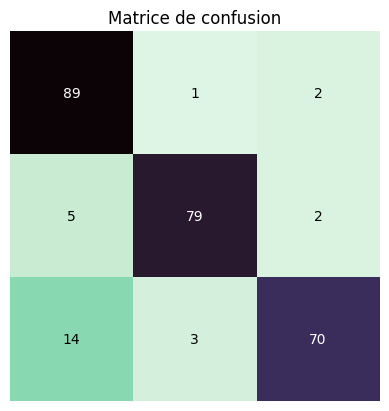

In [31]:
# matrice de confusion sert à savoir si on est bon sur qqchose ou si on confond des chose
cf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_res)
fig, ax = plt.subplots()
im = ax.imshow(cf_matrix,cmap='mako_r')
for i in range(len(cf_matrix)):
    for j in range(len(cf_matrix[i])):
        col = 'white'
        if cf_matrix[i,j]<(cf_matrix.max()/4):
            col = 'black'
        ax.text(j, i, cf_matrix[i, j],ha="center", va="center", color=col)
ax.set_title("Matrice de confusion")
plt.axis('off')
plt.show()

category 3 ça déconne le plus = point faible
13 fois category 1 et 3 confondu

# Autres

## SHAP

utiliser la methode SHAP ou LIME pour savoir ou est-ce que le model deconne dans la reconnaissance

In [20]:
import shap

# Ensure the input data shape is correct
X_train_sample = X_train[:100].astype('float32') / 255.0  # Use a sample of 100 images, properly normalized

# Use DeepExplainer, which works with deep learning models like CNNs
explainer = shap.DeepExplainer(model, X_train_sample)

C:\Users\Poste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Poste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\Poste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-pa

In [21]:
# Test on a new image from X_test
test_image = X_test[:1].astype('float32') / 255.0

# Get the SHAP values for the test image
shap_values = explainer.shap_values(test_image)

C:\Users\Poste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 224, 224, 3))']
  warnings.warn(msg)
C:\Users\Poste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


In [22]:
shap_values.shape

(1, 224, 224, 3, 3)

In [23]:
import math

res_test = model.predict(test_image)
	
def getPixelsAndValues(imageId):
    # Get the original image from X_test and multiply by 255 to bring it back to the 0-255 pixel range
    pixels = X_test[imageId] * 255
    pixels = np.expand_dims(pixels, axis=0)  # Add batch dimension for SHAP
    
    # Get SHAP values for this specific image
    list_values = []
    for i in range(len(shap_values)):  # Loop over the number of classes (e.g., 3 classes)
        values = shap_values[i][imageId]  # Get SHAP values for the image for each class
        list_values.append(values)  # Collect SHAP values for the image
    
    return pixels, list_values, res_test[imageId]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [21.905764..255.0].


Model prediction (class probabilities): [1.4761786e-03 4.8117872e-06 9.9851912e-01]


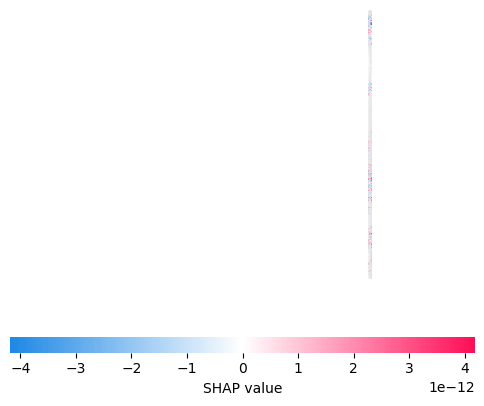

In [24]:
# Get the values for the third image (index 0)
pixels, list_values, res = getPixelsAndValues(0)

# Print the prediction result for the selected image
print("Model prediction (class probabilities):", res)

# Remove the batch dimension before plotting (squeeze the image to shape (224, 224, 3))
pixels = np.squeeze(pixels, axis=0)

# Use SHAP's image plot function to visualize the SHAP values
shap.plots.image(list_values,pixels)

# Evaluation des performances (C4)

In [32]:
model.summary() # mettre la bonne fonction pour faire le résumé du model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,508,043 (127.82 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,696 (85.22 MB)

In [33]:
model.save('./model/test_model2.h5')